Processing CHIME FRB180916.J0158+65
=====

see CHIME et al. 2020b "Periodic activity from a fast radio burst source"    
This notebook processes the bursts using the data released by CHIME and dedisperses the data further to study how the DM affects the final trend

  0%|          | 0/25 [00:00<?, ?it/s]

Processing with delta dm: -0.5


C:\Users\hmsmo\AppData\Roaming\Python\Python37\site-packages\skimage\measure\block.py:87: RuntimeWarning: Mean of empty slice
  **func_kwargs)
B:\dev\sadtrombone\universal\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\universal\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]
100%|██████████| 25/25 [00:06<00:00,  3.86it/s]


,amplitude,xo,yo,sigmax,sigmay,theta,drift (mhz/ms),angle
13.0,200.000000,80.294925,64.328205,12.813579,1.759827,1.569231,4062.827545,1.569231
14.0,649.314367,80.375611,64.411376,8.420559,-2.710737,2.143134,-9.868245,2.143134
15.0,178.019273,140.355924,64.272833,18.275735,5.381179,1.836163,-23.393653,1.836163
15.5,506.557763,176.380357,64.343676,3.425176,8.370467,0.500237,-11.631378,-1.070559
16.0,449.010463,80.286198,64.131362,2.356481,4.773796,0.252045,-24.688582,-1.318752
18.0,2681.366250,80.466977,64.406987,13.647895,3.380344,1.800886,-27.142600,1.800886
19.0,1281.046031,80.371761,64.329168,8.276806,2.740718,2.130530,-10.146908,2.130530
21.0,311.594880,80.290908,64.328803,8.114973,-4.218965,1.942805,-16.294772,1.942805
23.0,4203.404890,80.480024,64.028555,13.507572,2.111249,1.731032,-39.337882,1.731032
24.0,140.499915,80.153676,64.136503,2.565344,5.989152,72.498677,-25.752021,70.927881


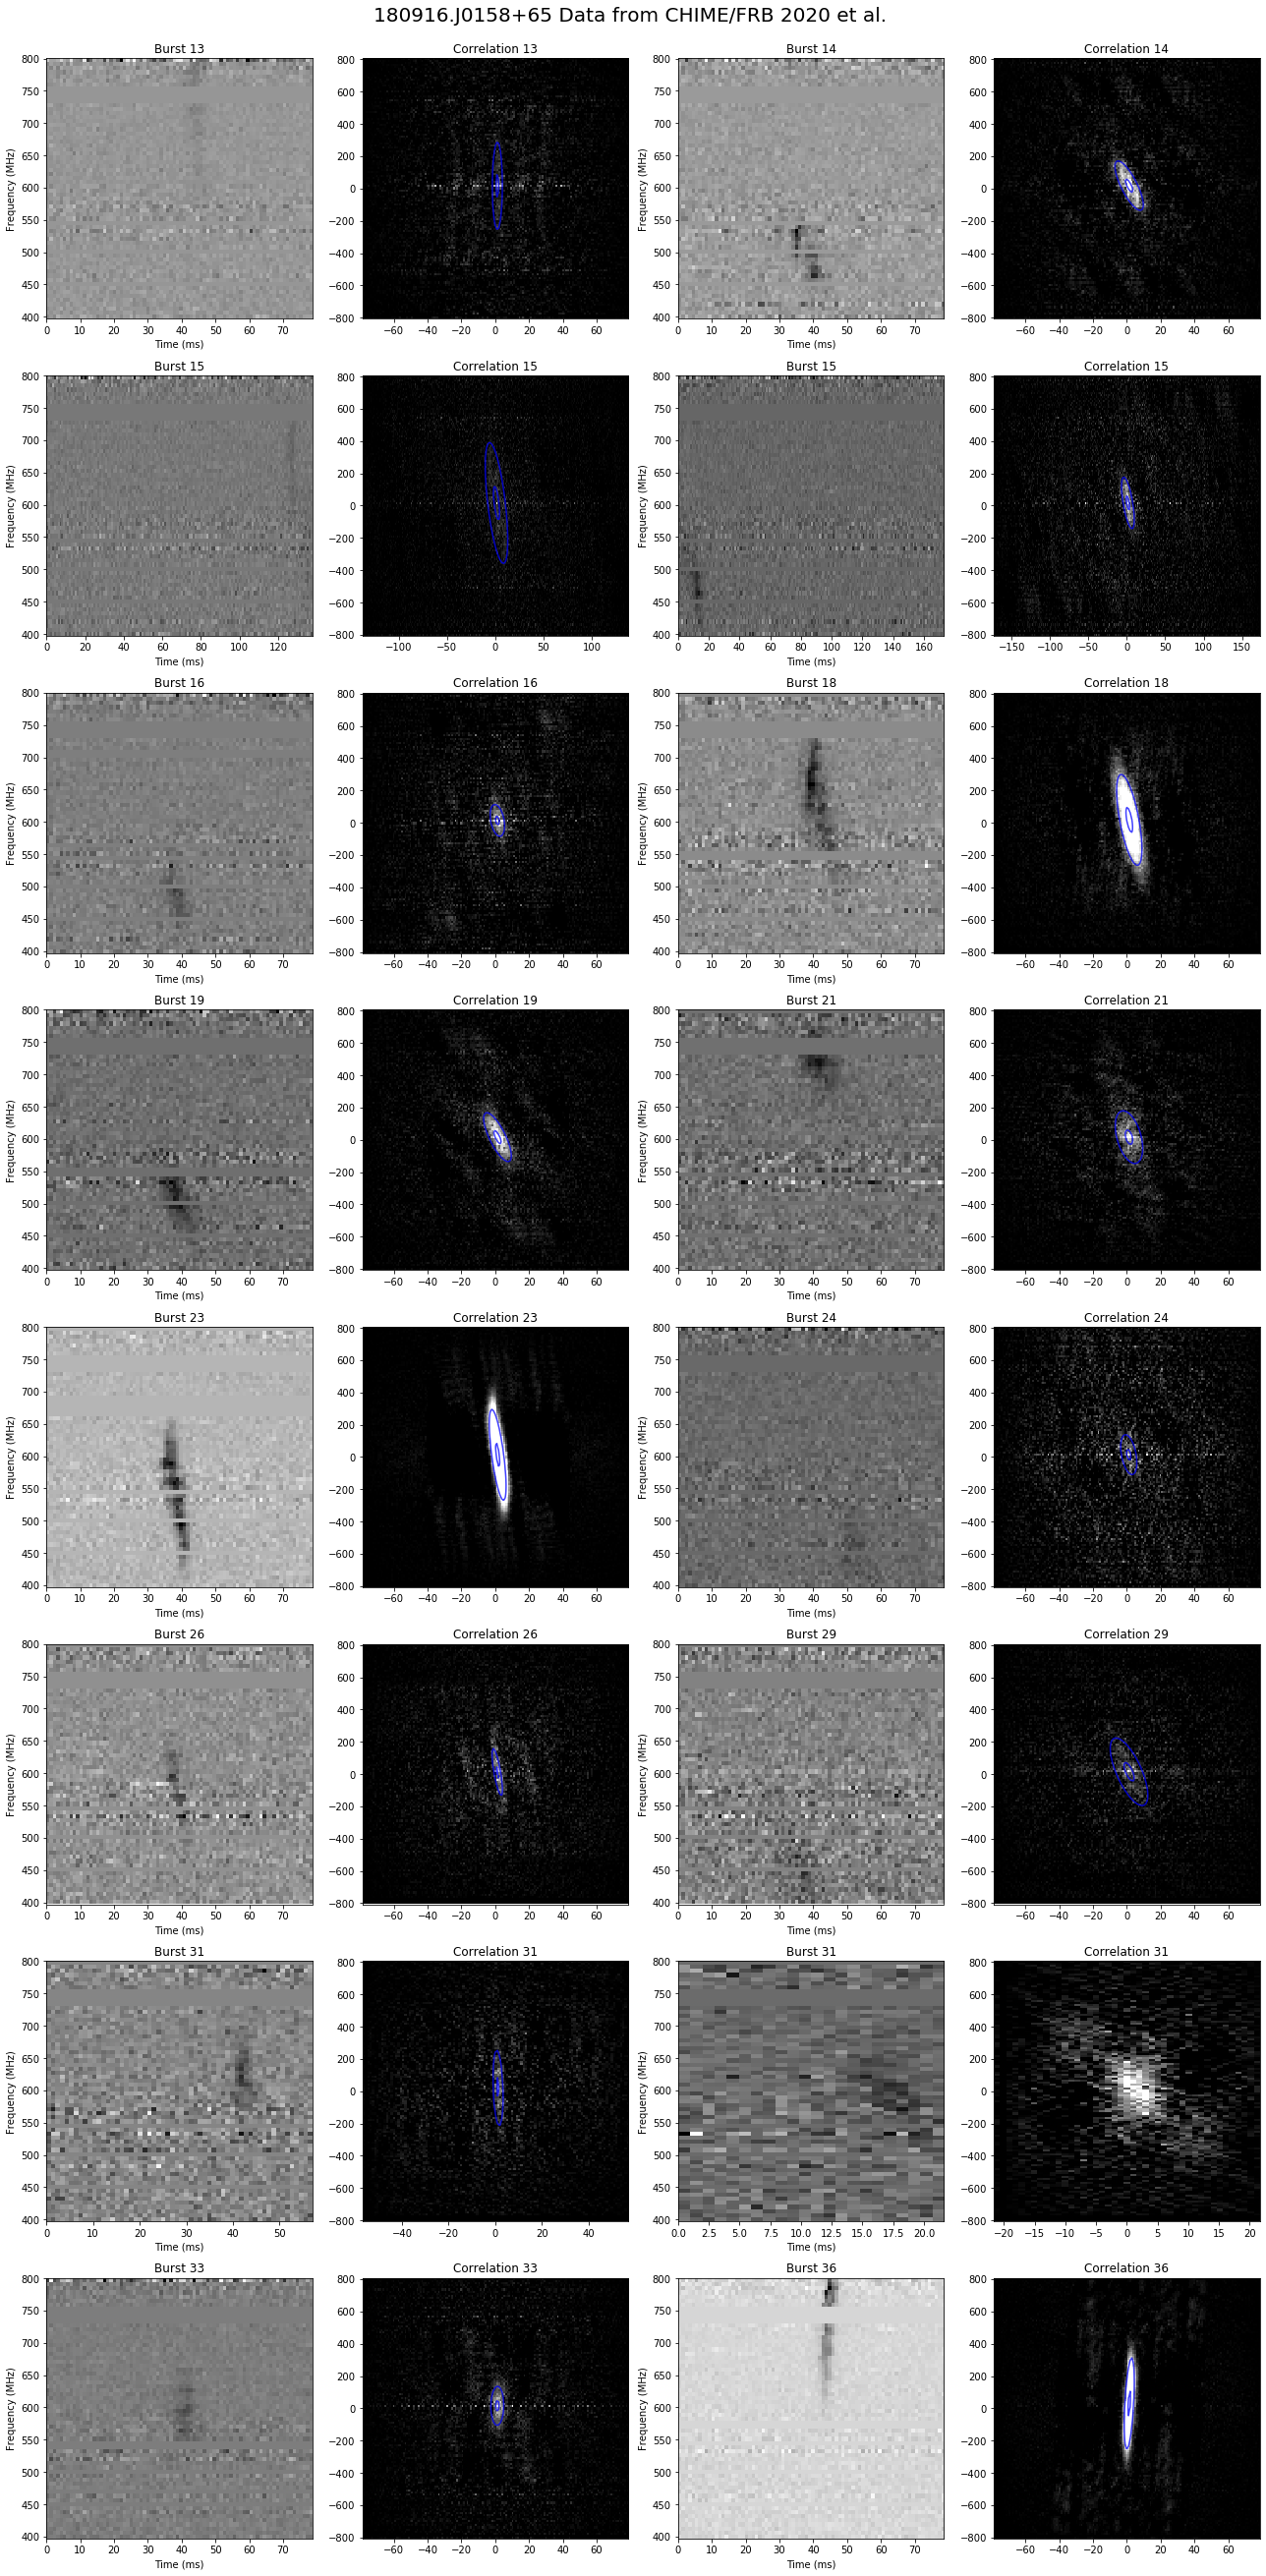

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import os
from tqdm import tqdm
import skimage.measure
import corrfns, fitburst
import itertools

folder = 'data/CHIME_180916.J0158+65'
burstfiles = [s for s in os.listdir(folder) if '16k' in s]
parameterfile = '{}/chime_180916_fit_params_ddm-half_redo.csv'.format(folder)
errorfile     = '{}/chime_180916_param_errors_ddm-half_redo.csv'.format(folder)

cmap = plt.get_cmap('gray_r')
cmap.set_bad(color = 'w', alpha = 1.)

if os.path.exists(parameterfile):
    popts = pd.read_csv(parameterfile, index_col=0)
    perrs = pd.read_csv(errorfile, index_col=0)
else:
    popts, perrs = [], []

drifts       = []
drift_errors = []
red_chisqs   = []
angles       = [] # standardize theta to be in [0, pi] 
keys         = []

def dedisperse(intensity, DM, nu_high, chan_width, timestep):
    dedispersed = np.copy(intensity)

    shifts = [0 for i in range(0, len(intensity))]

    for i, row in enumerate(dedispersed):
        nu_low = nu_high - i*chan_width
        deltat = 4.14937759336e6 * (nu_low**-2 - nu_high**-2) * DM
        channelshift = -int(round(deltat/timestep))
        dedispersed[i] = np.roll(dedispersed[i], channelshift)

    return dedispersed

def processBurst(burstwindow, burstkey, p0=[], popt_custom=[], bounds=(-np.inf, np.inf), clip=None, ploti=None):
    """
    Given a waterfall of a burst, will use the 2d autocorrelation+gaussian fitting method to find the drift and make a plot of the burst and fit.
    Parameters are added to the global lists above before being saved in a table. Eventually I may want to make this more standalone
    """
    corr = corrfns.auto_corr2D_viafft(burstwindow)
    if clip != None:
        corr = np.clip(corr, None, clip)
    #print(burstwindow.shape, corr.shape)
    #### Autocorr noise
    autocorr_sigma = np.std( corr[:, 0:100] )
    # print('autocorr_sigma', autocorr_sigma)
    # auto_sigmas.append(autocorr_sigma)

    #### Fit Gaussian to autocorrelation. Load from parameter file if already found.
    if os.path.exists(parameterfile):
        # print('loading fit...')
        popt, perr = popts.loc[burstkey][:6], perrs.loc[burstkey][:6]
    else:        
        print("finding fit {}...".format(burstkey))
        try:
            popt, pcov = fitburst.fitgaussiannlsq(corr, p0=p0, sigma=autocorr_sigma, bounds=bounds)
            perr = np.sqrt(np.diag(pcov))
            print('solution nlsq:', popt)
            print('parameter 1sigma:', perr)
            #print('pcov diag:', np.diag(pcov))
        except (RuntimeError, ValueError):
            print('no fit found')
            popt, perr = [-1,-1,-1,-1,-1,-1], [-1,-1,-1,-1,-1,-1]
            if popt_custom != []:
                popt = popt_custom
    popts.append(popt)
    perrs.append(perr)

    x, y = np.meshgrid(range(0, corr.shape[1]), range(0, corr.shape[0]))
    #popt[5] = 0.1
    if popt_custom == []:
        popt_custom = popt
    fitmap = fitburst.twoD_Gaussian((y, x), *popt_custom).reshape(corr.shape[0], corr.shape[1])
    
    # calculate reduced chisquared
    residuals = corr - fitmap
    chisq = np.sum((residuals / autocorr_sigma) ** 2)
    red_chisq = chisq / (corr.shape[0]*corr.shape[1] - len(popt)) # this is chisq/(M-N)
    red_chisqs.append(red_chisq)
    # print('reduced chisq:', red_chisq)
    
    # Calculate drifit
    time_res = 0.98304 # ms
    freq_res = 6.25 # MHz
    lowest_freq = 400.20751953125 # MHZ

    theta = popt[5] if abs(popt[3]) > abs(popt[4]) else popt[5] - np.pi/2
    angles.append(theta) #if theta > 0 else angles.append(theta + 2*np.pi)
    slope = np.tan(theta) 
    conversion = freq_res / (time_res)
    drift = conversion * slope # MHz/ms
    theta_err = perr[-1] # do i need to correct this for pixel scale?
    drift_error = conversion * (theta_err * (1/np.cos(theta))**2) 
    
    drifts.append(drift)
    drift_errors.append(drift_error)
    
    #### Plot
    extents = (0, 
               time_res*burstwindow.shape[1],
               lowest_freq - freq_res/2., 
               lowest_freq + freq_res*burstwindow.shape[0])
    
    corrextents = (-extents[1], extents[1], -(extents[3]-extents[2])*2, (extents[3]-extents[2])*2)
    
    if ploti == None:
        plt.figure(figsize=(15, 5))
        plt.subplot(121)
    else:
        plt.subplot(8, 4, next(ploti))
    plt.title("Burst {}".format(burstnum))
    plt.imshow(burstwindow, aspect='auto', cmap=cmap, extent=extents, origin='lower') # white is 0, black is 1
    plt.xlabel("Time (ms)")
    plt.ylabel("Frequency (MHz)")
    #plt.colorbar()

    if ploti == None:
        plt.subplot(122)
    else:
        plt.subplot(8, 4, next(ploti))
    plt.title("Correlation {}".format(burstnum))
    plt.imshow(corr, aspect='auto', cmap='gray', extent=corrextents, origin='lower')
    plt.clim(0, np.max(corr)/10)
    #plt.colorbar()
    if popt[0] > 0:
        plt.contour(fitmap, [popt_custom[0]/4, popt_custom[0]*0.9], colors='b', alpha=0.75, extent=corrextents, origin='lower')
        
    return drift, drift_error
        
wellfit      = [14, 18, 19, 21, 23, 26, 33, 36]
multiburst   = [15, 24, 31]
exclude      = [12, 17, 20, 22, 27, 28, 30, 34, 35, 37, 38] # too weak, cutoff, or strange morphologies
singleburst  = 31

plt.figure(figsize=(18,36))
plt.suptitle("180916.J0158+65 Data from CHIME/FRB 2020 et al. ", size=20, y=1.01)
ploti = itertools.count(start=1, step=1)
ddm = -0.5
print("Processing with delta dm:", ddm)
for filename in tqdm(burstfiles):
    burstnum = int(filename.split('burst_')[1][:2])
    if burstnum in exclude:
        continue
    
#     if burstnum != singleburst:
#         continue

    data = np.load("{}/{}".format(folder, filename))
    
    wfall = data["wfall"]
    downsample = 256
    wfall_down = skimage.measure.block_reduce(wfall, block_size=(downsample, 1), func=np.nanmean)
    # print(wfall_down.shape, wfall.shape)
    
    dt_s = data["dt_s"]
    center_freq_mhz = data["center_freq_mhz"]
    df_mhz = center_freq_mhz[1] - center_freq_mhz[0]
    # print(dt_s, center_freq_mhz[0], center_freq_mhz[-1], df_mhz)
    
    burstwindow = wfall_down - wfall_down[:, 0:20].mean(axis=1)[:,None]
    burstwindow = np.nan_to_num(wfall_down)
    burstwindow = dedisperse(burstwindow, ddm, 800, 6.25, 0.98304)
    
    ### PROCESS
    # set up initial guesses for problem bursts
    if burstnum == 13:
        p0 = [56.68995265, 80.41119967, 64.11432329, 20.4976088, 3, 1.8]
        bounds = (0, (200, *(np.inf,)*5))
        clip = None
    elif burstnum == 15:
        p0 = []
        bounds = (0, np.inf)
        clip = 5500
    elif burstnum == 16:
        p0 = []
        bounds = (0, np.inf)
        clip = 4000
    elif burstnum == 24:
        p0 = []
        bounds = (0, np.inf)
        clip = 2000
    elif burstnum == 26:
        p0 = []
        bounds = (0, np.inf)
        clip = 3000
    elif burstnum == 29:
        p0 = [56.68995265, 80.41119967, 64.11432329, 15, 3, 2.1]
        bounds = (0, (100, *(np.inf,)*5))
        clip = None
    elif burstnum == 31:
        p0 = [100, 59, 64.11432329, 10, 2, 1.7]
        bounds = (0, (200, *(np.inf,)*5))
        clip = None
    else:
        p0 = []
        bounds = (-np.inf, np.inf)
        clip = None
        
    # split multi bursts
    if burstnum in multiburst:
        if burstnum == 15:
            tsplit = 140
            processBurst(burstwindow[:, :tsplit], burstnum, bounds=bounds, ploti=ploti)
            keys.append(burstnum)
            
            processBurst(burstwindow[:, tsplit+4:], 15.5, bounds=bounds, clip=clip, ploti=ploti)
            keys.append(15.5)
        elif burstnum == 24:
            tsplit = 80
            
            processBurst(burstwindow[:, :tsplit], burstnum, bounds=bounds, clip=clip, ploti=ploti)
            keys.append(burstnum)
            
            #processBurst(burstwindow[:, tsplit:], burstnum+1, bounds=bounds, clip=clip, ploti=ploti)
            #keys.append(burstnum+1)
        elif burstnum == 31:
            tsplit = 58
            
            processBurst(burstwindow[:, :tsplit], burstnum, bounds=bounds, clip=clip, p0=p0, ploti=ploti)
            keys.append(burstnum)
            
            processBurst(burstwindow[:, tsplit:], burstnum+1, ploti=ploti)
            keys.append(burstnum+1)
    else:
        processBurst(burstwindow, burstnum, p0=p0, bounds=bounds, clip=clip, ploti=ploti)
        keys.append(burstnum)
               
    plt.tight_layout()
# plt.savefig('bursts180916.png')

select_bursts = keys
if not os.path.exists(parameterfile):
    popts = pd.DataFrame(popts, index=keys, columns=['amplitude', 'xo', 'yo', 'sigmax', 'sigmay', 'theta'])
    perrs = pd.DataFrame(perrs, index=keys, columns=['amp_error', 'xo_error', 'yo_error', 'sigmax_error', 'sigmay_error', 'angle_error'])

    try:
        popts['drift (mhz/ms)']       = drifts
        popts['angle']                = angles
        perrs['drift error (mhz/ms)'] = drift_errors
        perrs['red_chisq']            = red_chisqs

        popts.to_csv(parameterfile)
        perrs.to_csv(errorfile)
    except ValueError:
        print('not updating database')
    
    display(popts.loc[select_bursts])
else:
    newparams = pd.DataFrame(popts.loc[select_bursts], index=keys, columns=['amplitude', 'xo', 'yo', 'sigmax', 'sigmay', 'theta', 'drift (mhz/ms)', 'angle'])
    newparams['drift (mhz/ms)']       = drifts
    newparams['angle']                = angles
    display(newparams.loc[select_bursts])



### Baseband data

(64, 900)
(64, 900)
(64, 600)
(64, 900)


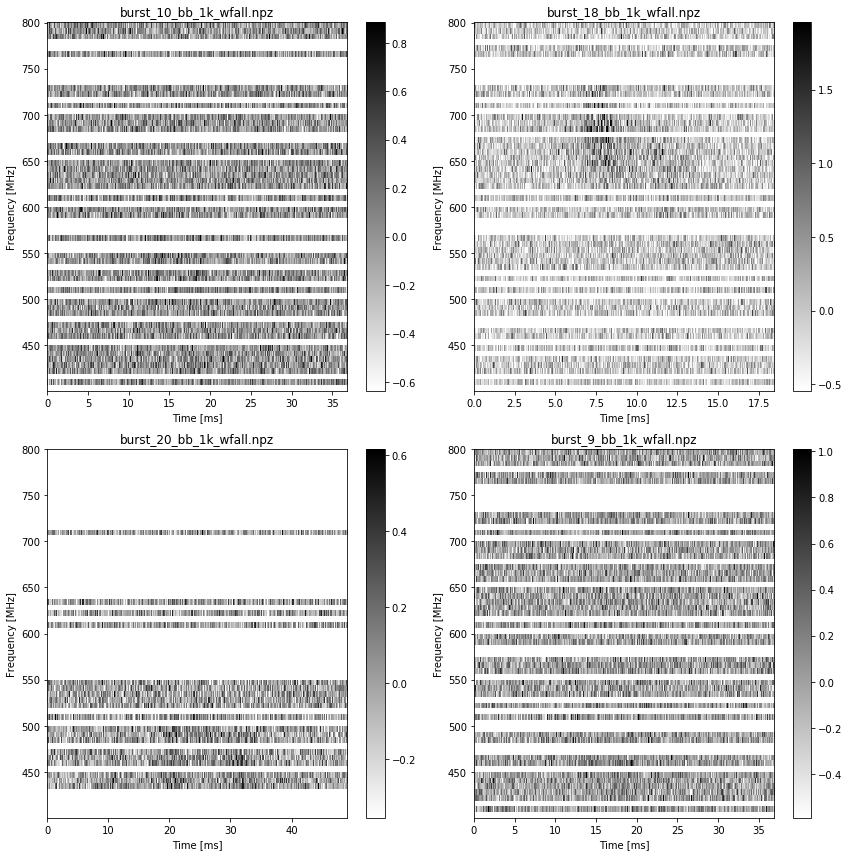

In [2]:
burstfiles = [s for s in os.listdir(folder) if 'bb' in s]

plt.figure(figsize=(12,12))
cmap = plt.get_cmap('gray_r')
cmap.set_bad(color = 'w', alpha = 1.) # potentially hides important errors in the data!

for fname in burstfiles:
    data = np.load("{}/{}".format(folder, fname))
    wfall = data["wfall"]
    wfall_z = np.nan_to_num(wfall)
    
    dt_s = data["dt_s"]
    center_freq_mhz = data["center_freq_mhz"]
    df_mhz = center_freq_mhz[1] - center_freq_mhz[0]
    
    plt.subplot(2,2,burstfiles.index(fname)+1)
 
    bb_downsample = 16
    plt.title(fname)
    plt.imshow(wfall[::16,:], origin="lower", aspect="auto", interpolation="nearest", cmap=cmap,
               extent=(0, 1000*dt_s*wfall.shape[1], center_freq_mhz[0]-df_mhz/2., center_freq_mhz[-1]+df_mhz/2.))
    plt.clim(np.min(wfall_z)*0.5, np.max(wfall_z)*0.5)
    plt.colorbar()
    plt.xlabel("Time [ms]")
    plt.ylabel("Frequency [MHz]")
    print(wfall[::16,:].shape)

plt.tight_layout()